In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import pickle as pk
from sklearn.neighbors import NearestNeighbors
from copy import deepcopy
import utils as u

In [1]:
def generate_msts(synapses_df, cells_df, k=6, soma_k=10):
    """Generate a minimum spanning tree for each cell in the dataset.
    
    Parameters
    ----------
    synapses_df : pandas.core.frame.DataFrame
        A dataframe of synapse data.
        Must include columns for ctr_pt_x, ctr_pt_y, ctr_pt_z, and post_pt_root_id.
        Can optionally include columns for pre_pt_root_id and pre_cell_type.
    cells_df : pandas.core.frame.DataFrame
        A dataframe of cell data, including columns for pt_root_id, pt_x, pt_y, pt_z, and cell_type.
    k : int
        The number of nearest neighbors to use when constructing the minimum spanning tree.
    soma_k : int
        The number of nearest neighbors to use when constructing the minimum spanning tree for the soma.
    Returns
    -------
    msts : dict
        A dictionary of minimum spanning trees, with the cell id as the key.
        Each tree is a networkx.Graph object. The nodes are synapse ids, and the edge weights are the distances between synapses.
        Graph attributes:
            G.graph['cell_id'] : int
                The cell id of the post-synaptic cell the synapses belong to.
            G.graph['cell_type'] : str
                The cell type of the post-synaptic cell the synapses belong to.
        Node attributes:
            G.nodes[syn_id]['pos'] : numpy.ndarray
                The xyz coordinates of the synapse.
            G.nodes[syn_id]['cell_type'] : str
                The cell type of the pre-synaptic cell the synapse belongs to.
            G.nodes[syn_id]['pre_cell_id'] : int
                The cell id of the pre-synaptic cell the synapse belongs to.
        Soma node attributes:
            G.nodes[-1]['pos'] : numpy.ndarray
                The xyz coordinates of the soma.
    """
    msts = []
    too_sparse = []
    count = 0
    total = len(syn_by_cell)
    for cell_id, syn_group in syn_by_cell:
        # If there are less than k synapses, skip this cell
        group_size = syn_group.shape[0]
        if group_size < k:
            too_sparse.append(cell_id)
            continue

        # Keep relevant rows of synapse table
        synapses = syn_group[['ctr_pt_x', 'ctr_pt_y', 'ctr_pt_z']]

        # Get the soma location for the cell
        cell_info = cells_df.loc[cells_df['pt_root_id'] == cell_id]
        soma_xyz = np.array(cell_info[['pt_x', 'pt_y', 'pt_z']].values[0])
        soma_xyz = np.matmul(soma_xyz, np.diag([4/1000, 4/1000, 40/1000]))

        # Add the soma location to the synapse table
        soma_df = pd.DataFrame(soma_xyz).T
        soma_df.columns = ['ctr_pt_x', 'ctr_pt_y', 'ctr_pt_z']
        soma_df.index = [-1]
        synapses_w_soma = pd.concat([synapses, soma_df])

        # Create a kdtree from the synapse locations
        kd_tree = NearestNeighbors(n_neighbors=k, algorithm='kd_tree').fit(synapses_w_soma.values)

        # Get the k nearest neighbors for each synapse and the soma
        distances, indices = kd_tree.kneighbors(synapses.values)
        if group_size >= soma_k:
            soma_distances, soma_indices = kd_tree.kneighbors(soma_xyz.reshape(1, -1), n_neighbors=soma_k)
        else:
            soma_distances, soma_indices = kd_tree.kneighbors(soma_xyz.reshape(1, -1), n_neighbors=group_size)

        # Subtract the "radius" of the soma from the soma distances
        soma_radius = soma_distances[0][1]
        soma_distances = soma_distances - soma_radius 

        # Create a graph from the synapse group
        nodes = list(synapses.index.values)
        G = nx.Graph(cell_id=cell_id)
        for node in nodes:
            node_ct = syn_group.loc[node, 'cell_type_pre'] if 'cell_type_pre' in syn_group.columns else 'unknown'
            node_pre_id = syn_group.loc[node, 'pre_pt_root_id'] if 'pre_pt_root_id' in syn_group.columns else -1
            G.add_node(node, pos=synapses.loc[node, ['ctr_pt_x', 'ctr_pt_y', 'ctr_pt_z']].values,
                             cell_type=node_ct,
                             pre_cell_id=node_pre_id)
        nodes.append(-1)
        G.add_node(-1, pos=soma_xyz)

        # Add edges according to the kdtree
        for i in range(len(indices)):
            syn_id = nodes[i]
            for j in range(len(indices[i])):
                if i != indices[i][j]:
                    G.add_edge(syn_id, nodes[indices[i][j]], weight=distances[i][j])
        
        # Add edges from the soma to its nearest neighbors, corrected for the radius of the soma 
        for l in range(1,len(soma_indices[0])):
            G.add_edge(-1, nodes[soma_indices[0][l]], weight=soma_distances[0][l])

        # Get the minimum spanning tree
        mst = nx.minimum_spanning_tree(G)
        # Add the graph to the dictionary
        msts.append(mst)
        
        count += 1
        print(f'{cell_id}, {count}/{total}, {count/total}: {mst.number_of_nodes()} nodes, {mst.number_of_edges()} edges')
    
    print('Done!')
    return msts, too_sparse

In [3]:
# Import cells and synapse data
cells = pd.read_csv('data/cells_no_repeats.csv', index_col=0)
synapses_all = pd.read_csv('data/synapses_w_ids.csv', index_col=0)
synapses_all.set_index('synapse_id', inplace=True)

print('Cells: ', cells.shape)
print('Synapses: ', synapses_all.shape)
display(cells.head())
display(synapses_all.head())

Cells:  (56209, 5)
Synapses:  (5421809, 17)


cell_type          pt_root_id   pt_x    pt_y   pt_z
Unnamed: 0                                                    
0                23P  864691135639004475  71136  110528  20220
1                23P  864691135771677771  72576  108656  20291
2                23P  864691135864089470  79632  121456  16754
3                23P  864691135560505569  80128  124000  16563
4                23P  864691136315868311  80144  126928  16622

pre_pt_root_id     post_pt_root_id   size cell_type_pre  \
synapse_id                                                                
0           864691135564683351  864691136811959667    960           23P   
1           864691135614119115  864691135508912649   7576           23P   
3           864691135113147801  864691136022555784    684           23P   
4           864691135194393642  864691135341362885  23172           23P   
5           864691136272938174  864691135683554546   3660           23P   

            cb_x_pre  cb_y_pre  cb_z_pre cell_type_post  cb_x_post  cb_y_post  \
synapse_id                                                                      
0            557.248   570.560    732.52            23P    791.744    483.968   
1            774.720   504.960    895.68            23P    807.936    459.584   
3            883.072   451.456    817.84            23P    851.520    483.840   
4            781.248   449.984    696.88            23P    798.720    465.152   
5            762.368   473.792    773.68            23P    820.352    446.784   

            cb_z_post  cb_x_diff  cb_y_diff  cb_z_diff  ctr_pt_x  ctr_pt_y  \
synapse_id                                                                   
0              780.44   -234.496     86.592     -47.92   637.608   371.352   
1              870.28    -33.216     45.376      25.40   805.376   488.376   
3              759.96     31.552    -32.384      57.88   858.328   516.648   
4              758.56    -17.472    -15.168     -61.68   789.400   478.040   
5              719.08    -57.984     27.008      54.60   756.624   440.928   

            ctr_pt_z  
synapse_id            
0             720.20  
1             863.60  
3             775.88  
4             691.00  
5             710.60

In [6]:
key_info = ['ctr_pt_x', 'ctr_pt_y', 'ctr_pt_z', 'post_pt_root_id', 'pre_pt_root_id', 'cell_type_pre', 'cell_type_post']
synapses = synapses_all.loc[:, key_info]
print('Synapses: ', synapses.shape)
display(synapses.head())

Synapses:  (5421809, 7)


ctr_pt_x  ctr_pt_y  ctr_pt_z     post_pt_root_id  \
synapse_id                                                     
0            637.608   371.352    720.20  864691136811959667   
1            805.376   488.376    863.60  864691135508912649   
3            858.328   516.648    775.88  864691136022555784   
4            789.400   478.040    691.00  864691135341362885   
5            756.624   440.928    710.60  864691135683554546   

                pre_pt_root_id cell_type_pre cell_type_post  
synapse_id                                                   
0           864691135564683351           23P            23P  
1           864691135614119115           23P            23P  
3           864691135113147801           23P            23P  
4           864691135194393642           23P            23P  
5           864691136272938174           23P            23P

In [7]:
synapses_by_cell = synapses.groupby('post_pt_root_id')

In [8]:
print(len(synapses_by_cell))

56179


In [9]:
msts, _ = generate_msts(deepcopy(synapses_by_cell), cells)
print(len(msts))

864691134884741370, 1/56179, 1.7800245643389878e-05: 87 nodes, 86 edges
864691134884741626, 2/56179, 3.5600491286779756e-05: 74 nodes, 73 edges
864691134884742138, 3/56179, 5.3400736930169635e-05: 52 nodes, 51 edges
864691134884742906, 4/56179, 7.120098257355951e-05: 164 nodes, 162 edges
864691134884743162, 5/56179, 8.900122821694939e-05: 48 nodes, 47 edges
864691134884743418, 6/56179, 0.00010680147386033927: 100 nodes, 99 edges
864691134884743930, 7/56179, 0.00012460171950372915: 139 nodes, 138 edges
864691134884745210, 8/56179, 0.00014240196514711903: 122 nodes, 120 edges
864691134884747002, 9/56179, 0.0001602022107905089: 234 nodes, 232 edges
864691134884747514, 10/56179, 0.00017800245643389878: 36 nodes, 35 edges
864691134884748026, 11/56179, 0.00019580270207728866: 185 nodes, 184 edges
864691134884748282, 12/56179, 0.00021360294772067854: 106 nodes, 104 edges
864691134884749562, 13/56179, 0.00023140319336406842: 91 nodes, 90 edges
864691134884749818, 14/56179, 0.000249203439007458

In [11]:
with open('data/min_spanning_trees.pkl', 'wb') as f:
    pk.dump(msts, f)

In [7]:
# See what results look like

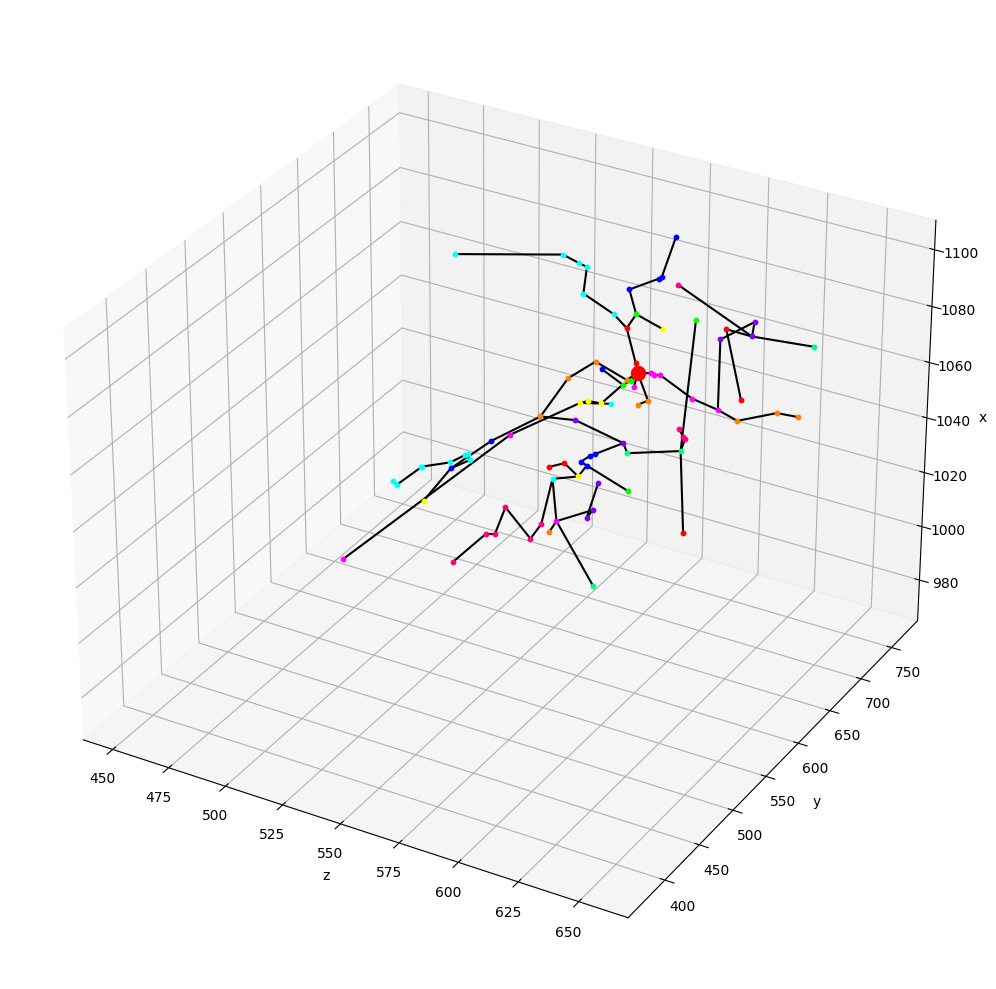

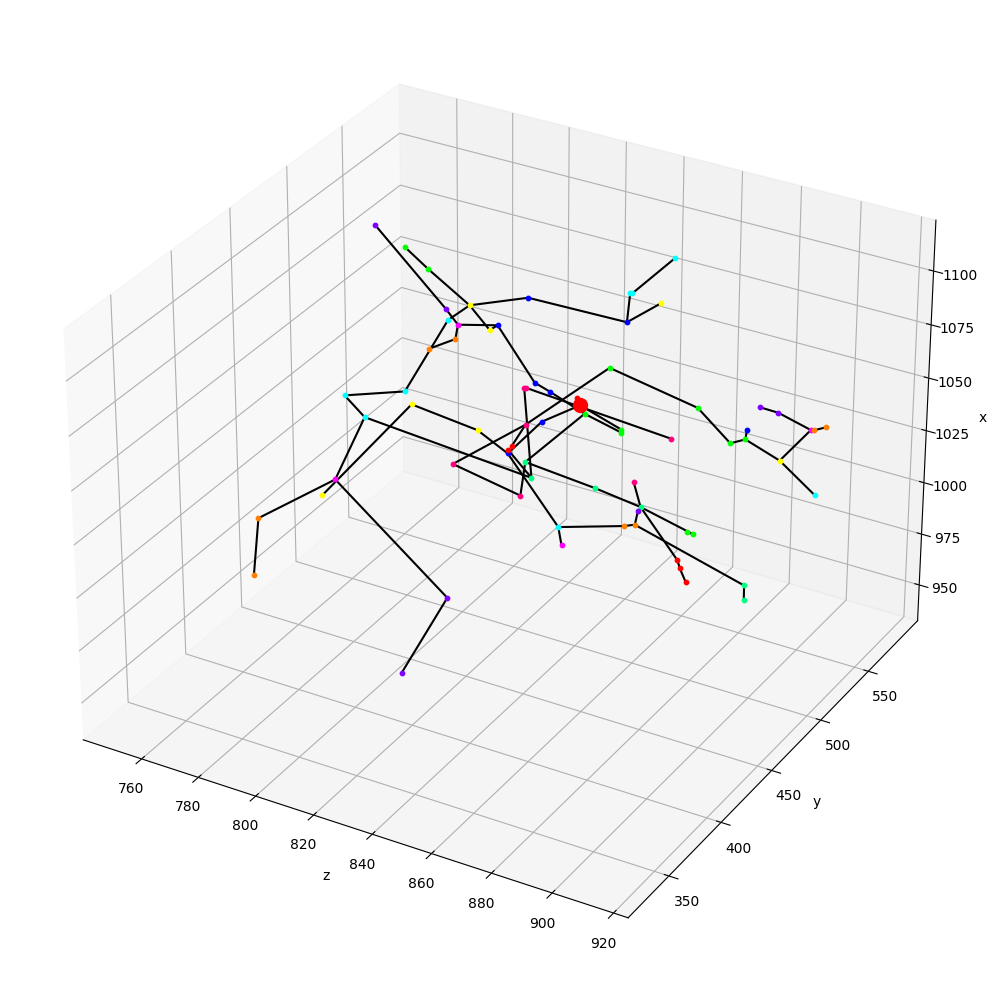

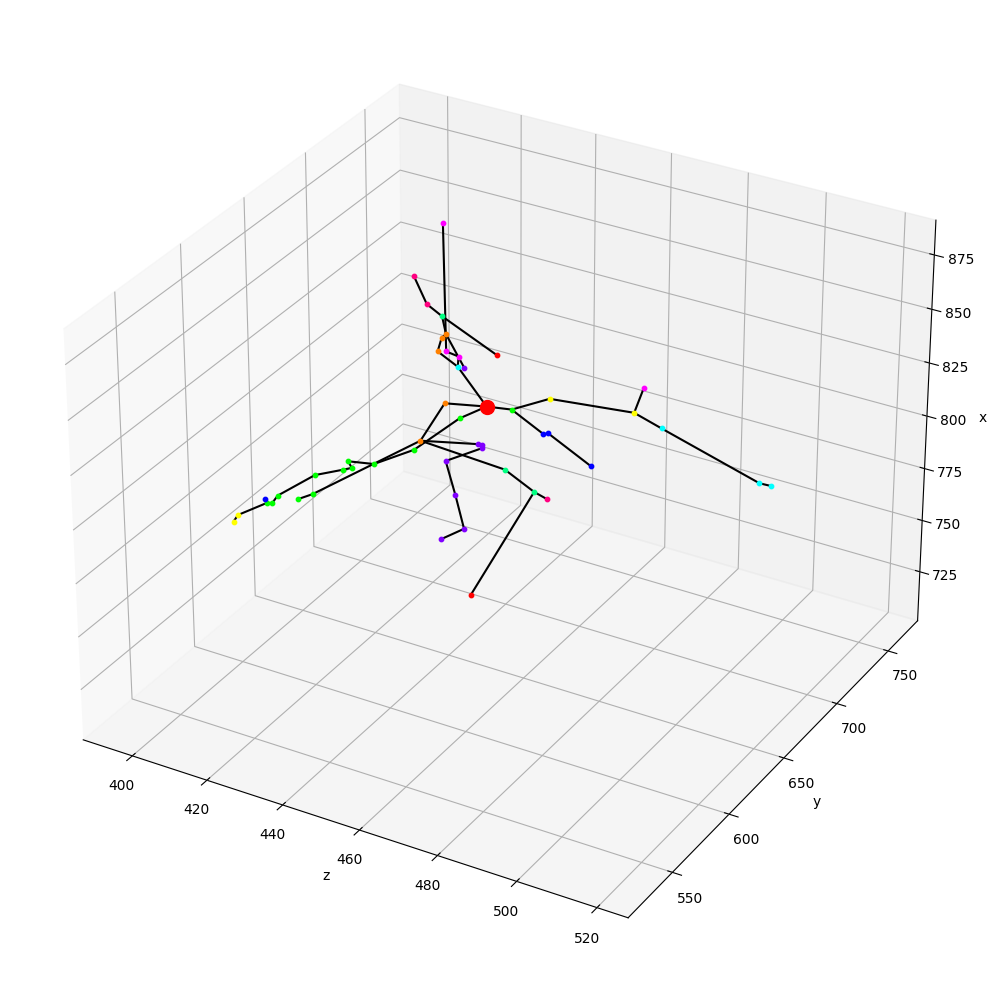

KeyError: 657643

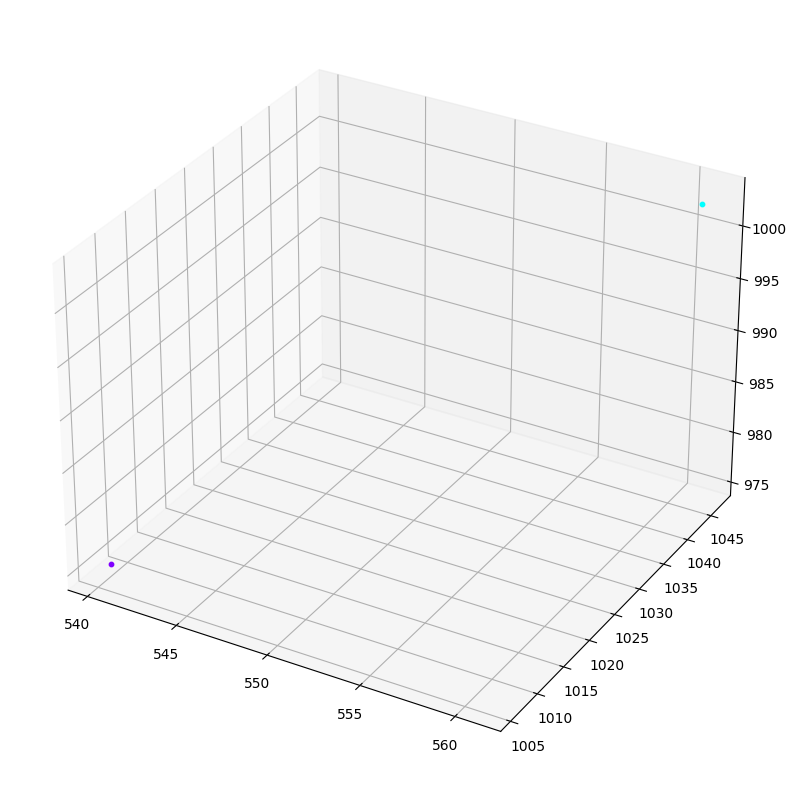

In [8]:
for cell_id, mst in msts.items():
    cur_synapses = synapses_by_cell.get_group(cell_id)
    u.plot_mst_3d(mst, cur_synapses)